In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns                  # For data visualization
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#setting working directory
import os
os.getcwd()
os.chdir('D:/.../problem')

In [3]:
df = pd.read_excel('CASE_V1.xlsx', sheet_name = 'CASE_V1')

## EDA

In [4]:
# fix column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')

## Feature engineering

In [5]:
df['remain_days'] = pd.Series(delta.days for delta in (df['charged_until_date'] - df['snapshot_date'])) + 1 
df['contract_len_days'] = pd.Series(delta.days for delta in (df['charged_until_date'] - df['contract_start_date'])) + 1 
df['osn_flag'] = np.where(df.osnplay_count == 0, 0, 1)

In [6]:
# put a column for churn
df['churn'] = np.where(df.churn_reason.isna(), 0, 1)

In [7]:
#retain only specific payment groups 
payment_grp = ['A', 'E', 'D']
df = df.loc[df.method_of_payment_group_1.isin(payment_grp), :]

In [8]:
#deleting duplicate column
# df['hardware_profile'].equals(df['hardware_profile_group_1'])
df = df.drop('hardware_profile_group_1', axis = 1)

In [9]:
#replace selected columns with 0 in place of NANs
df['rejection_count'].fillna(0,inplace= True)
df['zero_days_ratio'].fillna(0,inplace= True)
df['count_zero_days_disconnect'].fillna(0,inplace= True)
df['std_days_disconnect'].fillna(0,inplace= True)
df['max_days_disconnect'].fillna(0,inplace= True)
df['mean_days_disconnect'].fillna(0,inplace= True)

In [10]:
# check extent of missing values
missing = df.isna().sum().sort_values(ascending = False)/df.shape[0]
missing[missing >0]

disconnection_date    0.962708
churn_reason          0.962708
maingenre             0.932305
devicetype            0.932305
language              0.932305
dtype: float64

In [11]:
# remove rows where remain days are less than 0
df = df[df.remain_days >=-7]

## Univariate analysis

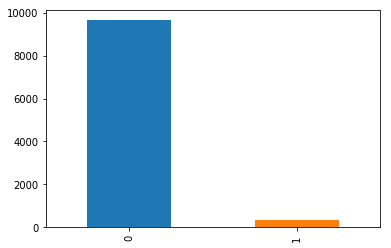

In [34]:
df['churn'].value_counts().plot.bar()

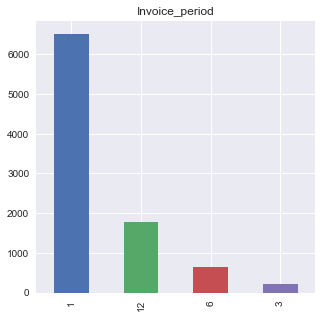

In [156]:
plt.figure(1)
df['invoice_period_numeric'].value_counts().plot.bar(figsize=(5,5), title= 'Invoice_period')
plt.show()

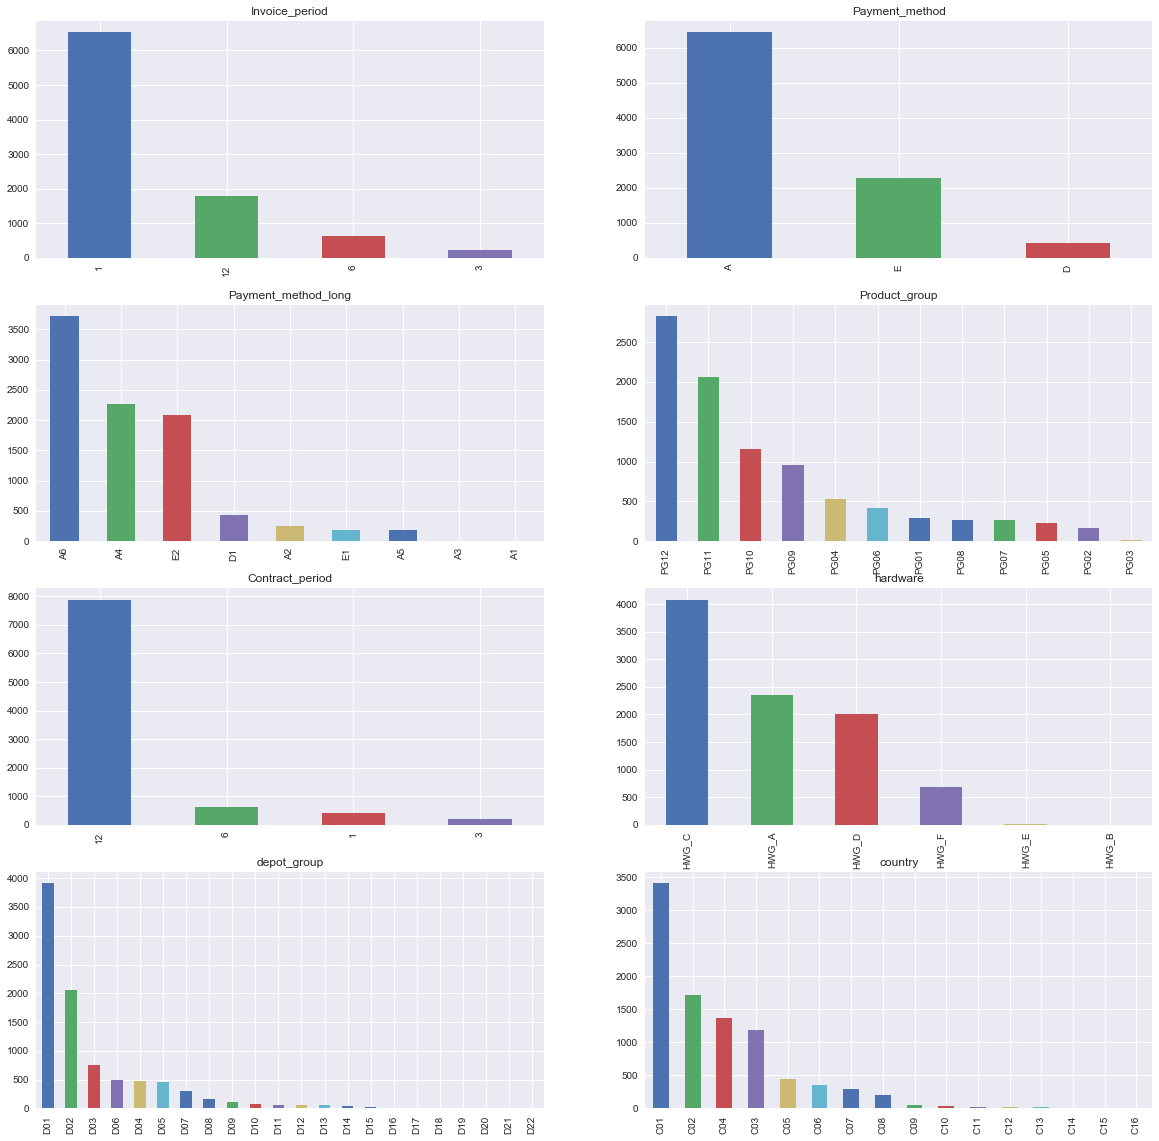

In [157]:
# categorical data 

plt.figure(1)
plt.subplot(421)
df['invoice_period_numeric'].value_counts().plot.bar(figsize=(20,20), title= 'Invoice_period')

plt.subplot(422)
df['method_of_payment_group_1'].value_counts().plot.bar(title= 'Payment_method')

plt.subplot(423)
df['method_of_payment_long'].value_counts().plot.bar(title= 'Payment_method_long')

plt.subplot(424)
df['product_group_5'].value_counts().plot.bar(title= 'Product_group')

plt.subplot(425)
df['contract_period_numeric'].value_counts().plot.bar(title= 'Contract_period')

plt.subplot(426)
df['hardware_profile'].value_counts().plot.bar(title= 'hardware')

plt.subplot(427)
df['depot_group_1'].value_counts().plot.bar(title= 'depot_group')

plt.subplot(428)
df['subscriber_country_long'].value_counts().plot.bar(title= 'country')

plt.show()

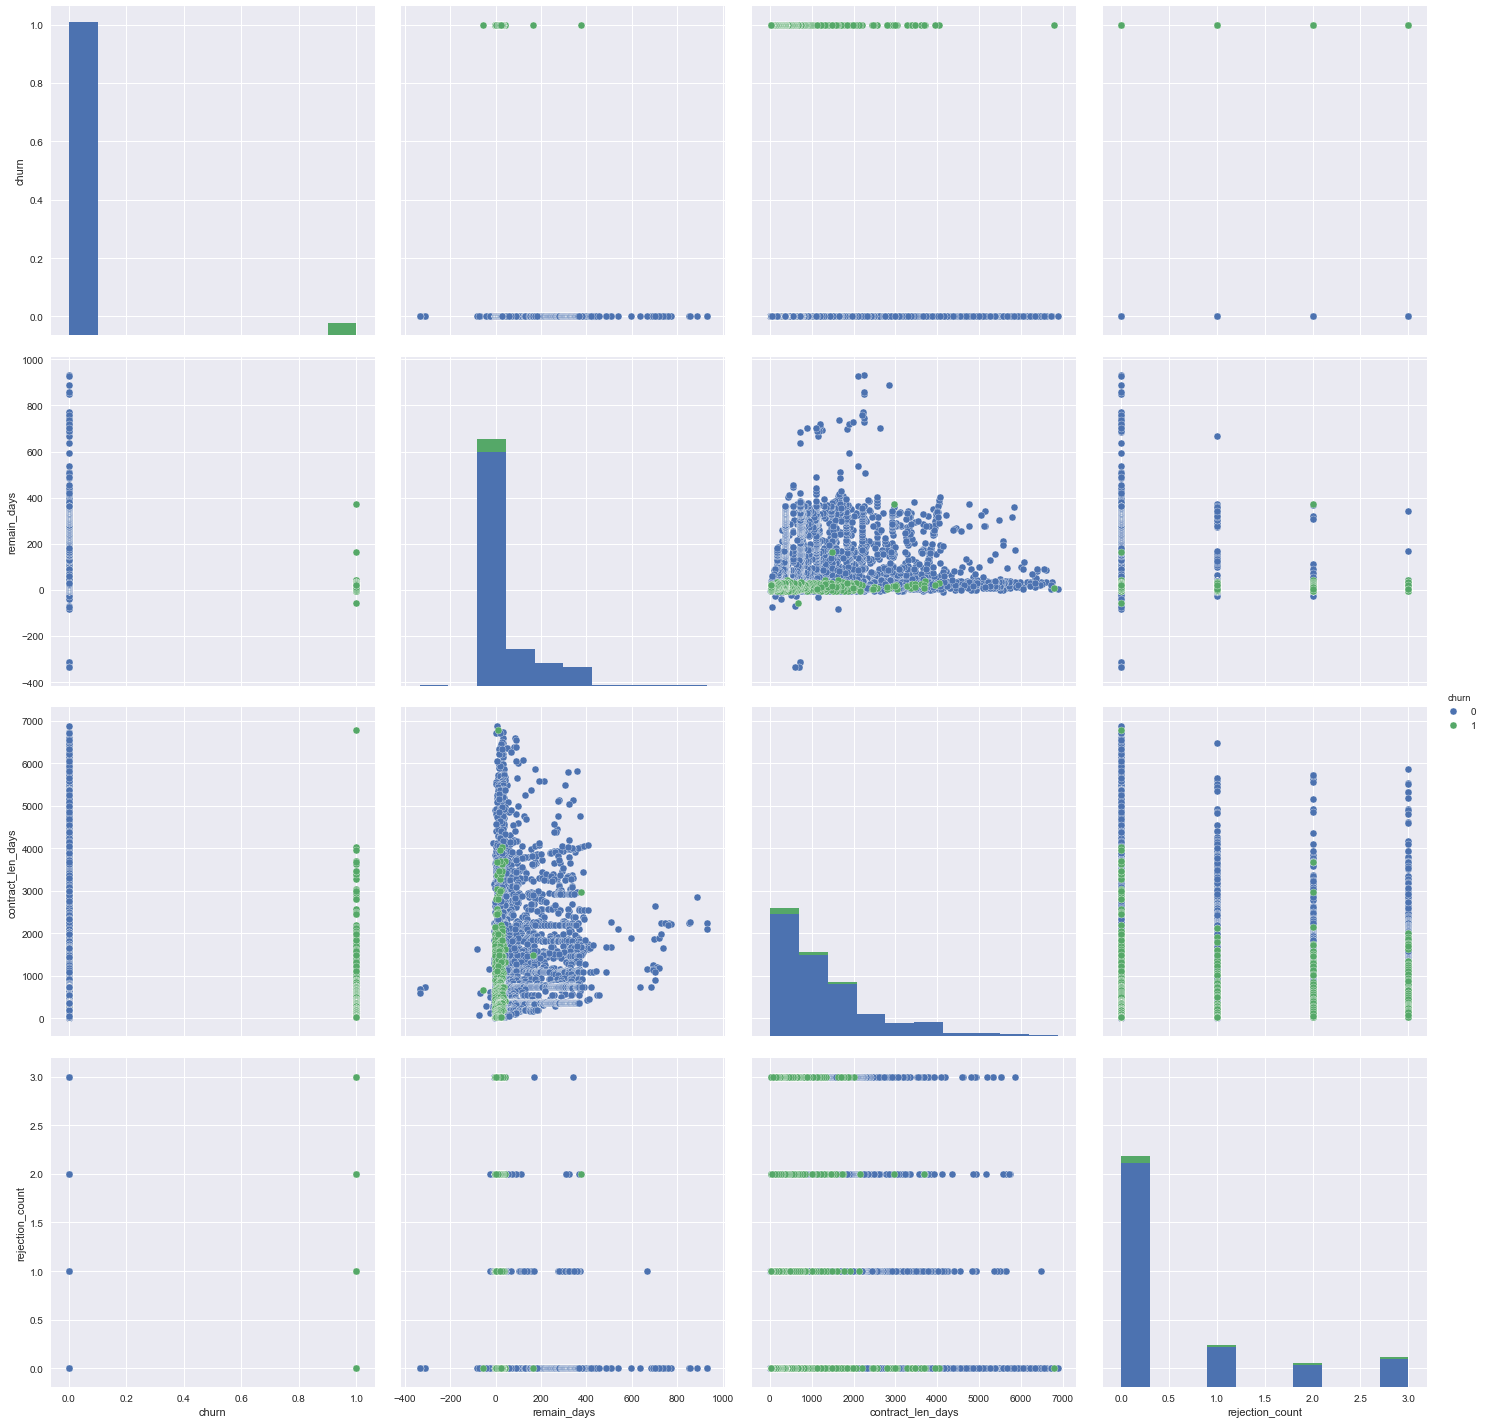

In [195]:
# Pair plot
sns.set()
cols = ['churn', 'remain_days', 'contract_len_days', 'rejection_count']
sns.pairplot(df[cols],size = 5 ,kind ='scatter', hue = 'churn')
plt.show()

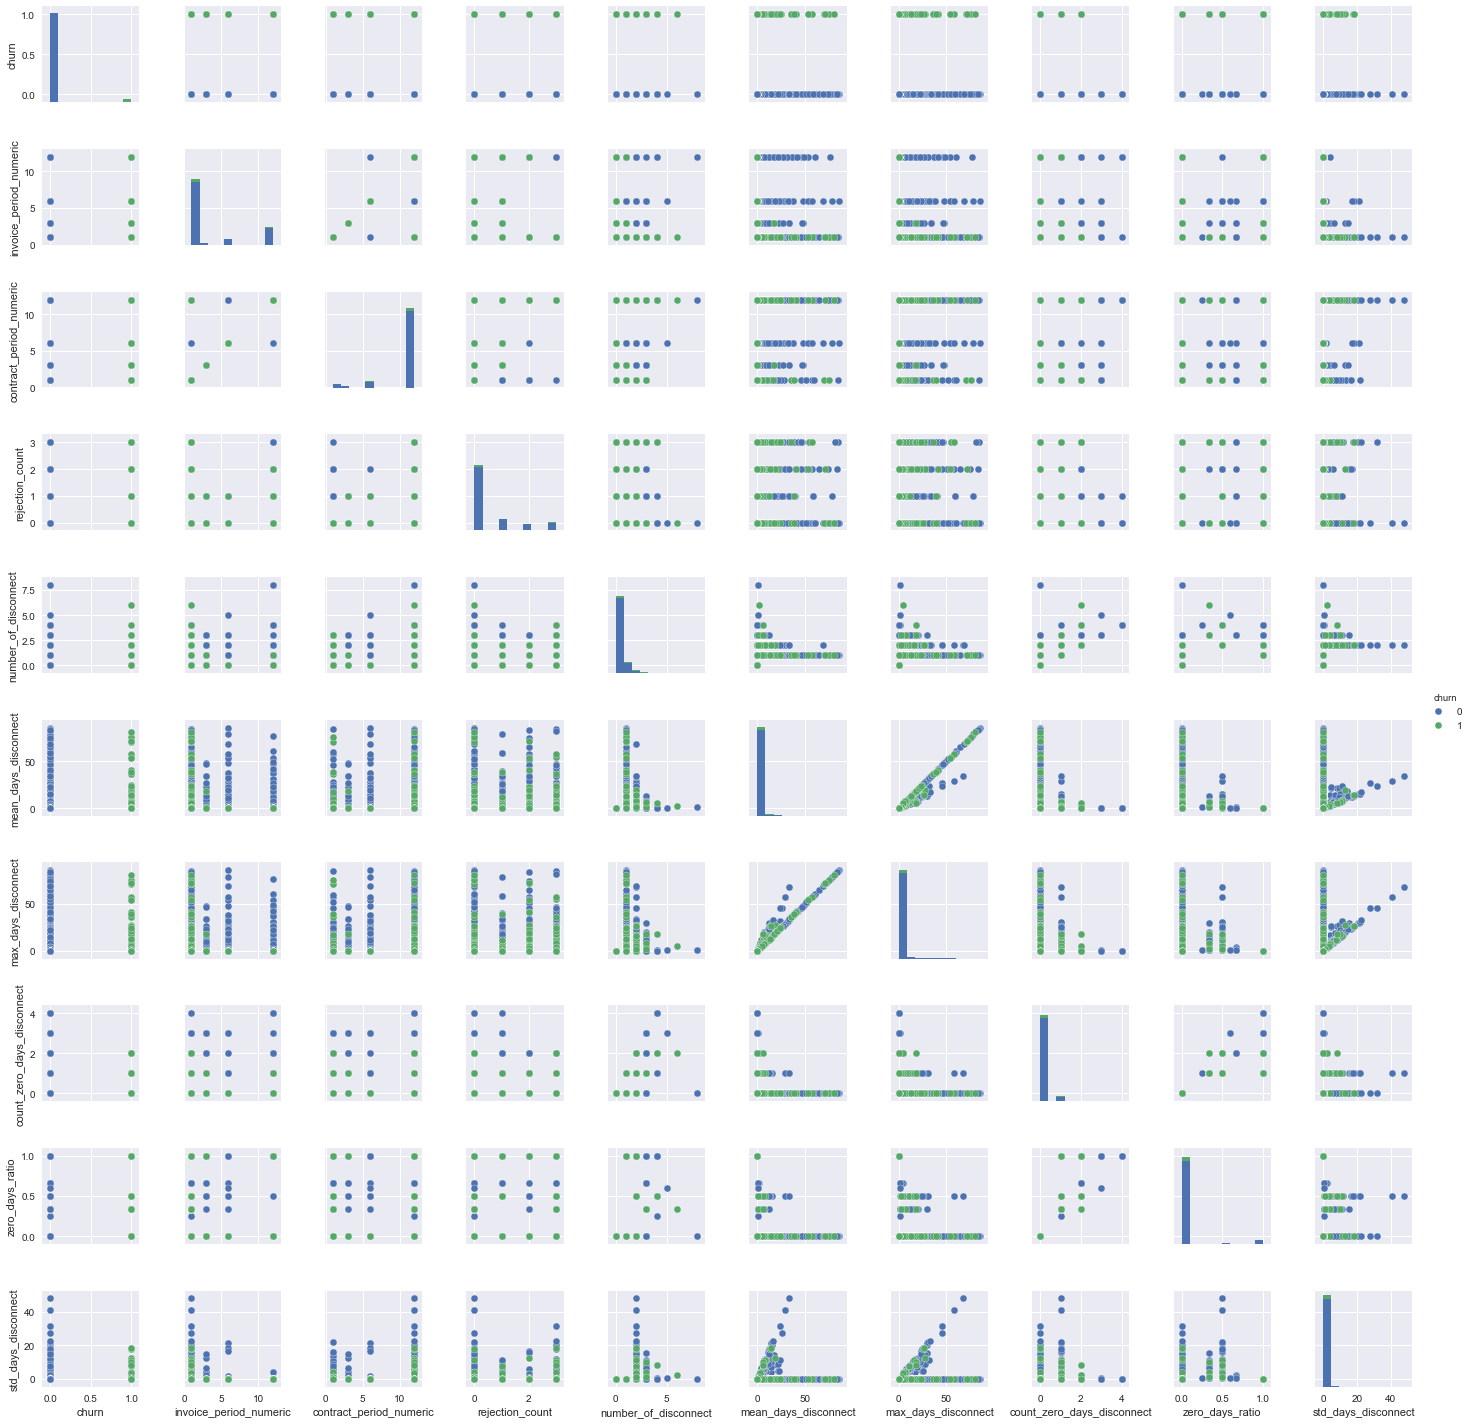

In [149]:
# Pair plot
sns.set()
cols = ['churn', 'invoice_period_numeric', 'contract_period_numeric', 'rejection_count', 'number_of_disconnect', 'mean_days_disconnect', 'max_days_disconnect', 'count_zero_days_disconnect', 'zero_days_ratio', 'std_days_disconnect']
sns.pairplot(df[cols],size = 2 ,kind ='scatter', hue = 'churn')
plt.show()

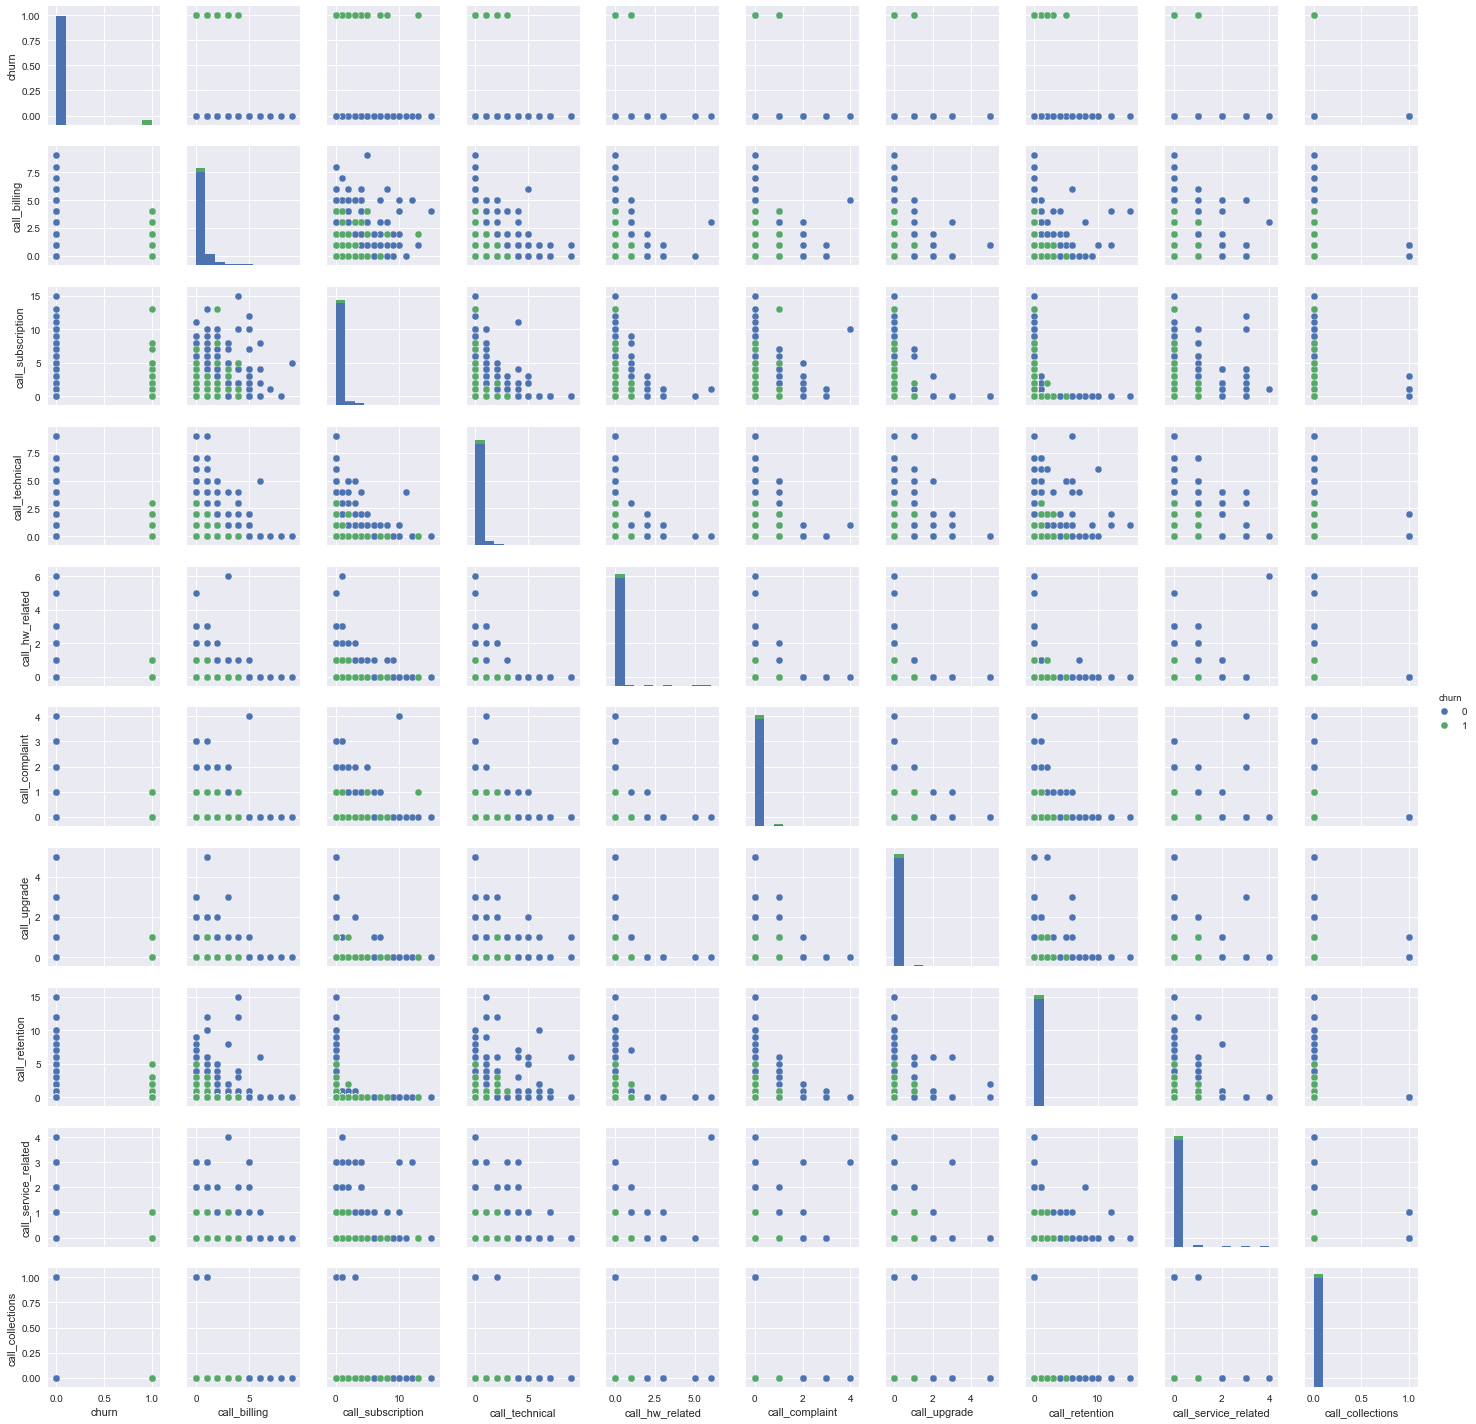

In [150]:
# Pair plot
sns.set()
cols = ['churn','call_billing', 'call_subscription', 'call_technical', 'call_hw_related', 'call_complaint', 'call_upgrade', 'call_retention', 'call_service_related', 'call_collections']
sns.pairplot(df[cols],size = 2 ,kind ='scatter', hue = "churn")
plt.show()

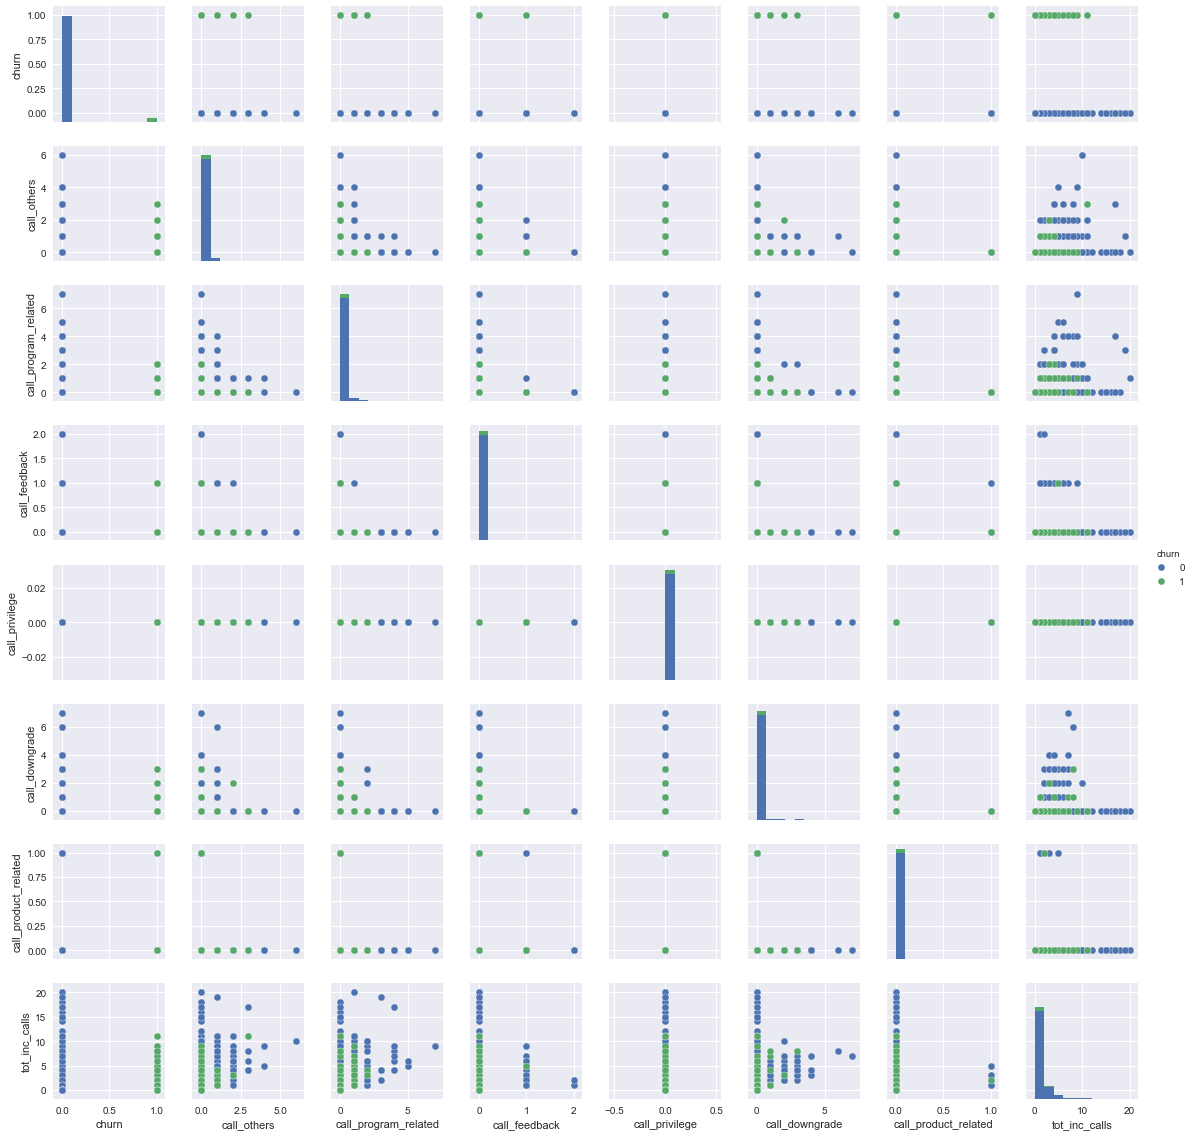

In [151]:
# Pair plot
sns.set()
cols = ['churn','call_others','call_program_related', 'call_feedback', 'call_privilege', 'call_downgrade', 'call_product_related', 'tot_inc_calls']
sns.pairplot(df[cols],size = 2 ,kind ='scatter', hue = "churn")
plt.show()

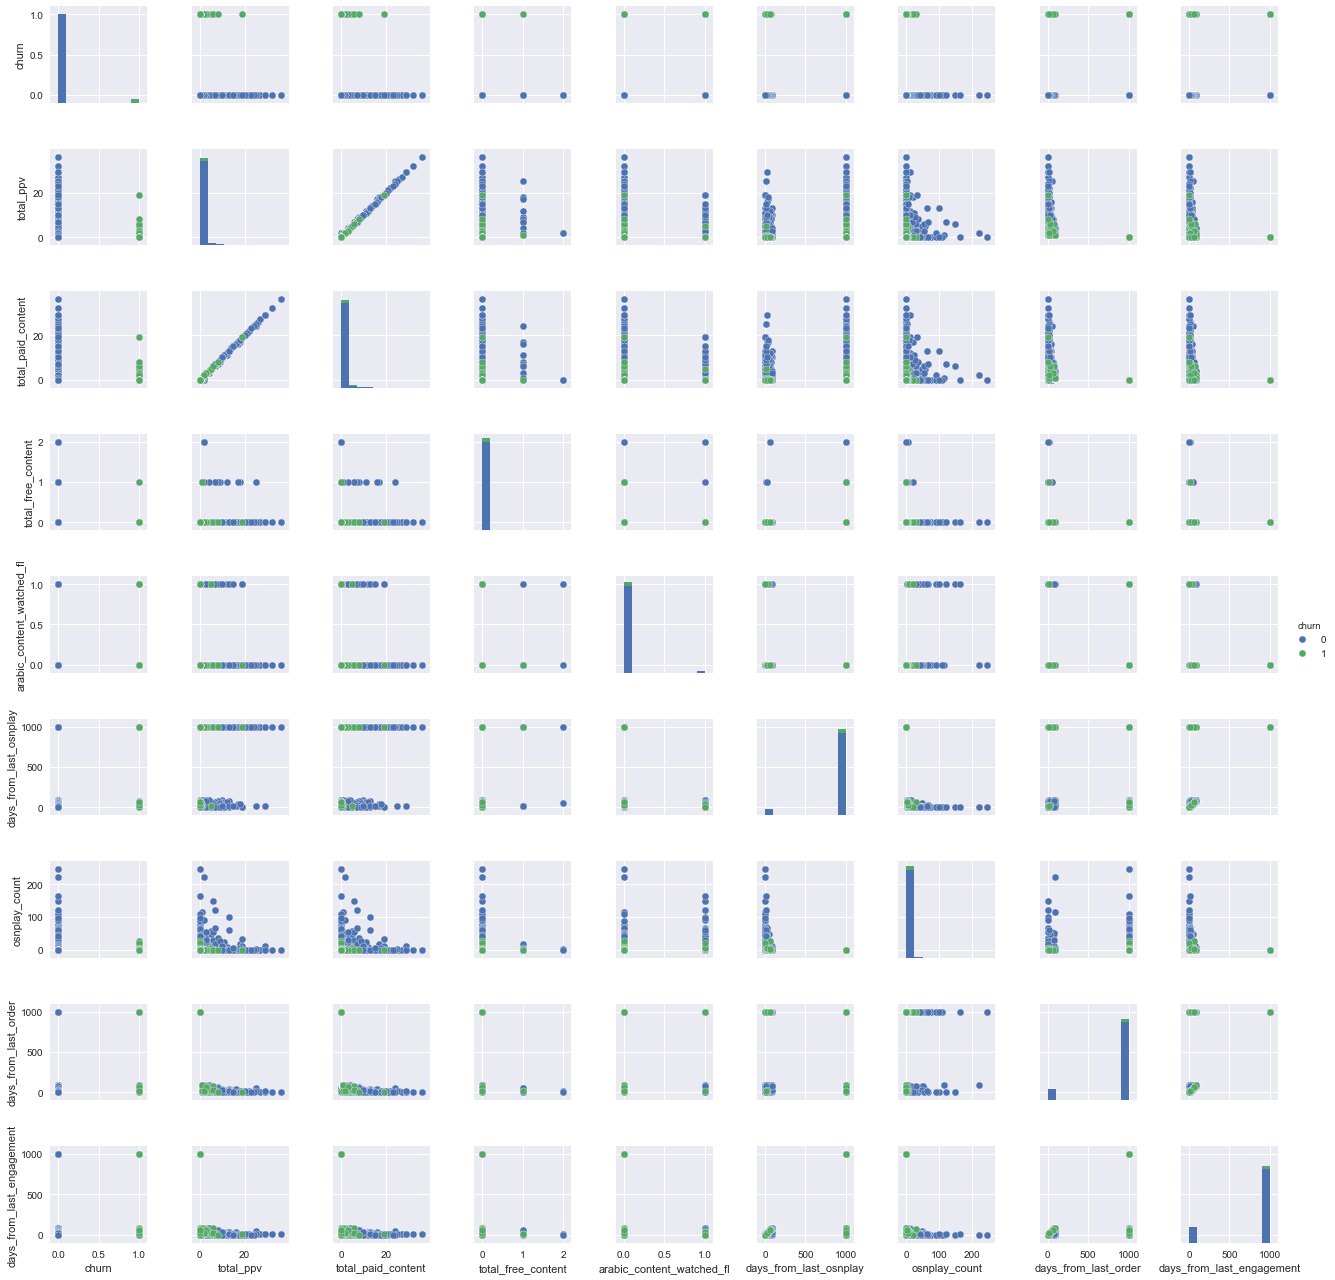

In [152]:
# Pair plot
sns.set()
cols = ['churn','total_ppv', 'total_paid_content', 'total_free_content', 'arabic_content_watched_fl', 'days_from_last_osnplay', 'osnplay_count', 'days_from_last_order' , 'days_from_last_engagement']
sns.pairplot(df[cols],size = 2 ,kind ='scatter',hue = 'churn')
plt.show()

In [ ]:
#strong co-relation with calls & engagement data

In [169]:
df.groupby(['method_of_payment_group_1', 'churn', 'churn_reason']).subscriber_no.count()

method_of_payment_group_1  churn  churn_reason
A                          1      Churn2           94
                                  Churn3          135
D                          1      Churn1           35
E                          1      Churn1           75
                                  Churn2            2
Name: subscriber_no, dtype: int64

In [170]:
df.groupby(['method_of_payment_group_1', 'churn']).subscriber_no.count()

method_of_payment_group_1  churn
A                          0        6203
                           1         229
D                          0         394
                           1          35
E                          0        2206
                           1          77
Name: subscriber_no, dtype: int64

In [434]:
df.shape

(9126, 53)

In [12]:
#remove duplicates
df = df.drop_duplicates(keep='first', inplace= False)

In [13]:
#subscriber duplication is present
df.groupby(['subscriber_no']).subscriber_no.count().sort_values(ascending = False).head(4)

subscriber_no
563     2
6081    2
2174    2
6395    2
Name: subscriber_no, dtype: int64

# Modeling

In [14]:
df1 = pd.get_dummies(df, columns = ['method_of_payment_group_1', 'depot_group_1'])

In [15]:
df1.drop(['snapshot_date','subscriber_no', 'contract_start_date', 'method_of_payment_long', 'product_group_5', 'hardware_profile', 'subscriber_country_long', 'product_long', 'language', 'maingenre', 'devicetype', 'charged_until_date', 'churn_reason', 'disconnection_date'],axis=1,inplace=True)

In [16]:
dfinal = df1.copy()
df1.drop(['churn'],axis=1,inplace=True)
x = df1
y = df.churn

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3, random_state = 0)

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6388, 61), (6388,), (2738, 61), (2738,))

In [19]:
y_train.sum(), y_test.sum()

(229, 111)

In [20]:
x_train.shape[0], x_test.shape[0]

(6388, 2738)

### feature scaling

In [21]:
# feature scaling
# options available: Normalizer()  MinMaxScaler()  RobustScaler()  StandardScaler()
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


# x_train['contract_len_days'] = sc_x.fit_transform(x_train.contract_len_days)
# x_test['contract_len_days'] = sc_x.transform(x_test.contract_len_days)

# x_train['remain_days'] = sc_x.fit_transform(x_train.remain_days)
# x_test['remain_days'] = sc_x.transform(x_test.remain_days)


# scale everything
sc_x = preprocessing.StandardScaler()
x_train_scl = pd.DataFrame(sc_x.fit_transform(x_train))
x_train_scl.columns = x_train.columns

x_test_scl = pd.DataFrame(sc_x.transform(x_test))
x_test_scl.columns = x_test.columns

In [22]:
x_test = x_test_scl
x_train = x_train_scl

In [23]:
y_test = y_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [24]:
x_test.shape, x_train.shape

((2738, 61), (6388, 61))

# altering weight of minor class

In [25]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
import scikitplot as skplt

In [29]:
#logistic Regression
parameters = [{'C': [0.1, 1, 10]}]
model = LogisticRegression(class_weight= 'balanced', random_state = 0)


grid_search = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs = -1, scoring= 'roc_auc' )
grid_search = grid_search.fit(x_train, y_train)

Accuracy: 0.757487216947
Precision: 0.114365411437
Recall: 0.738738738739
ROC_AUC: 0.788643230212
AUC: 0.774423545597
Confusion matrix:
[[1992  635]
 [  29   82]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


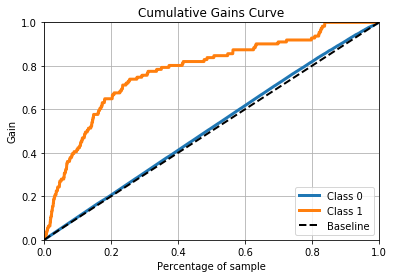

In [42]:
y_pred = grid_search.predict(x_test)
y_proba = grid_search.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

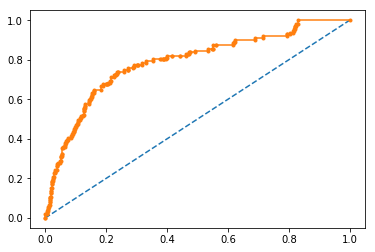

In [44]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba[:,1])
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# # show the plot
plt.show()

In [89]:
# Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier(class_weight = 'balanced', random_state = 0)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

timer(start_time) # timing ends here for "start_time" variable

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.8min finished



 Time taken: 0 hours 14 minutes and 52.85 seconds.


In [90]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

Accuracy: 0.959459459459
Precision: 0.5
Recall: 0.0540540540541
ROC_AUC: 0.817547848572
AUC Pr Rc: 0.813292075978
Confusion matrix:
[[2621    6]
 [ 105    6]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


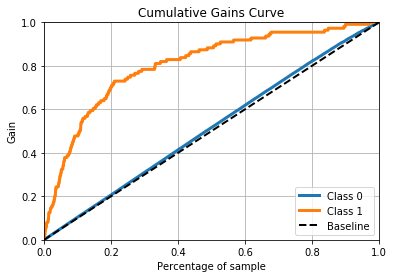

In [91]:
y_pred = rf_random.predict(x_test)
y_proba = rf_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [113]:
#XGBoost new

# parameter grid for XGBoost
params = {
        'min_child_weight': [9, 10, 11],
        'gamma': [0.3, 0.4, 0.5, 0.6],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5]
        }

print(params)

{'min_child_weight': [9, 10, 11], 'gamma': [0.3, 0.4, 0.5, 0.6], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0], 'max_depth': [2, 3, 4, 5]}


In [114]:
xgb = XGBClassifier(scale_pos_weight= 24 )

xgb_random = RandomizedSearchCV(xgb, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random.fit(x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished



 Time taken: 0 hours 2 minutes and 27.04 seconds.


Accuracy: 0.840029218408
Precision: 0.162886597938
Recall: 0.711711711712
ROC_AUC: 0.851248469634
AUC Pr Rc: 0.820084829583
Confusion matrix:
[[2221  406]
 [  32   79]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


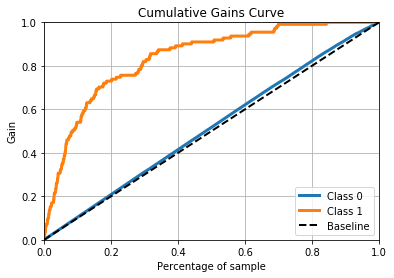

In [115]:
y_pred = xgb_random.predict(x_test)
y_proba = xgb_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [48]:
xgb_random.best_params_

{'subsample': 1.0,
 'min_child_weight': 9,
 'max_depth': 3,
 'gamma': 0.6,
 'colsample_bytree': 0.6}

In [49]:
xgb_random.best_score_

0.84941355251099959

<IPython.core.display.Javascript object>


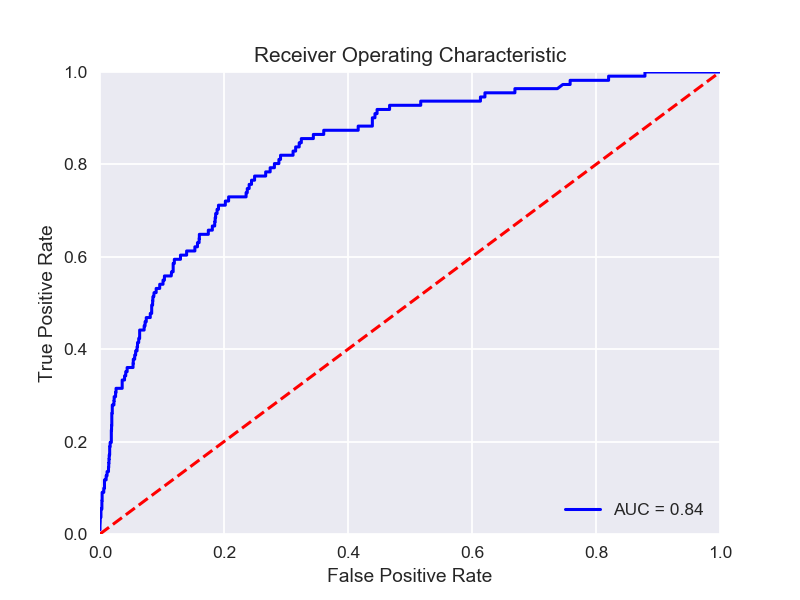

In [406]:
#ROC

# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_random.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [271]:
var_imp = xgb_random.best_estimator_.feature_importances_

In [272]:
var_imp = pd.DataFrame(var_imp)

In [273]:
col_names = x_test.columns.transpose()

In [274]:
col_names = col_names.to_frame()

In [275]:
var_imp_f = pd.concat([col_names.reset_index(drop = True), var_imp.reset_index(drop = True)], axis = 1)

In [276]:
#Export
var_imp_f.to_csv("20181029_var_imp_v1.csv",index=False)

In [116]:
#lift chart data
prob = xgb_random.predict_proba(x_test)


In [117]:
lift_chart = pd.concat([pd.DataFrame(prob[:,1]), y_test.reset_index(drop=True)], axis = 1)
lift_chart.head()

,0,churn
0,0.074940,0
1,0.004654,0
2,0.041197,0
3,0.428011,0
4,0.070592,0


In [118]:
#Export
lift_chart.to_csv("20181031_lift_xgb_1.csv",index=False)

In [50]:
#SVM

# parameter grid for SVM
params = {
        'C' : [0.001, 0.01, 0.1, 1, 10],
        'gamma' : [0.001, 0.01, 0.1, 1],
        }

print(params)

{'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}


In [55]:
svc = SVC(kernel = 'rbf', class_weight = 'balanced', verbose = True, random_state = 0, probability= True)
svc_random = RandomizedSearchCV(svc, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=True, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
svc_random.fit(x_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


[LibSVM]
 Time taken: 0 hours 3 minutes and 5.39 seconds.


In [56]:
svc_random.best_params_

{'gamma': 0.01, 'C': 1}

Accuracy: 0.788897005113
Precision: 0.112769485904
Recall: 0.612612612613
ROC_AUC: 0.775066272973
AUC Pr Rc: 0.751449880057
Confusion matrix:
[[2092  535]
 [  43   68]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


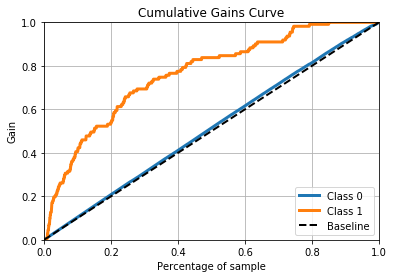

In [58]:
y_pred = svc_random.predict(x_test)
y_proba = svc_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

## reduce class imbalance by up-sampling 

In [59]:
from sklearn.utils import resample

In [60]:
dtest = pd.concat([x_train, y_train], axis = 1)

In [61]:
dtest.groupby(['churn']).count()

,invoice_period_numeric,contract_period_numeric,rejection_count,number_of_disconnect,mean_days_disconnect,max_days_disconnect,count_zero_days_disconnect,zero_days_ratio,std_days_disconnect,call_billing,...,depot_group_1_D13,depot_group_1_D14,depot_group_1_D15,depot_group_1_D16,depot_group_1_D17,depot_group_1_D18,depot_group_1_D19,depot_group_1_D20,depot_group_1_D21,depot_group_1_D22
churn,,,,,,,,,,,,,,,,,,,,,
0,6159,6159,6159,6159,6159,6159,6159,6159,6159,6159,...,6159,6159,6159,6159,6159,6159,6159,6159,6159,6159
1,229,229,229,229,229,229,229,229,229,229,...,229,229,229,229,229,229,229,229,229,229


In [62]:
data_majority = dtest[dtest['churn']==0]
data_minority = dtest[dtest['churn']==1]

data_minority_upsampled = resample(data_minority,replace=True,n_samples=6159, #same number of samples as majority classe
random_state=1) #set the seed for random resampling

# Combine resampled results
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

data_upsampled['churn'].value_counts()

1    6159
0    6159
Name: churn, dtype: int64

In [63]:
# get test train data sets

train_up = data_upsampled.copy()

train_up.drop(['churn'],axis=1,inplace=True)

x_train_up = train_up
y_train_up = data_upsampled.churn

x_train_up.shape, y_train_up.shape, x_test.shape, y_test.shape

((12318, 61), (12318,), (2738, 61), (2738,))

In [64]:
y_train_up.sum(), y_train.sum(), y_test.sum()

(6159, 229, 111)

In [65]:
#logistic Regression
parameters = [{'C': [0.1, 1, 10]}]
model = LogisticRegression(random_state = 0)

# Here we go
start_time = timer(None)

grid_search = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs = -1, scoring= 'roc_auc' )
grid_search = grid_search.fit(x_train_up, y_train_up)
y_pred = grid_search.predict(x_test)

timer(start_time)


 Time taken: 0 hours 0 minutes and 6.55 seconds.


Accuracy: 0.759313367421
Precision: 0.114084507042
Recall: 0.72972972973
ROC_AUC: 0.782449750855
AUC Pr Rc: 0.768269234121
Confusion matrix:
[[1998  629]
 [  30   81]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


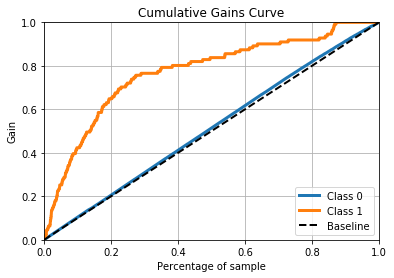

In [66]:
y_pred = grid_search.predict(x_test)
y_proba = grid_search.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [94]:
# Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier(random_state = 0)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_up, y_train_up)

timer(start_time) # timing ends here for "start_time" variable

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.4min finished



 Time taken: 0 hours 3 minutes and 30.26 seconds.


In [95]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

Accuracy: 0.955441928415
Precision: 0.310344827586
Recall: 0.0810810810811
ROC_AUC: 0.76536795646
AUC Pr Rc: 0.771153475208
Confusion matrix:
[[2607   20]
 [ 102    9]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


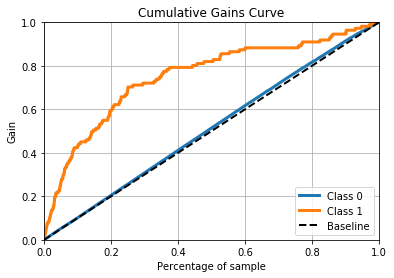

In [96]:
y_pred = rf_random.predict(x_test)
y_proba = rf_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [127]:
#XGBoost

# parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

print(params)

{'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]}


In [128]:
xgb = XGBClassifier()

xgb_random = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random.fit(x_train_up, y_train_up)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.1s finished



 Time taken: 0 hours 0 minutes and 32.72 seconds.


In [129]:
xgb_random.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 5,
 'colsample_bytree': 0.8}

In [130]:
print(xgb_random.best_score_)

0.966694338937


Accuracy: 0.878013148283
Precision: 0.173020527859
Recall: 0.531531531532
ROC_AUC: 0.834223260184
AUC Pr Rc: 0.823245233239
Confusion matrix:
[[2345  282]
 [  52   59]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


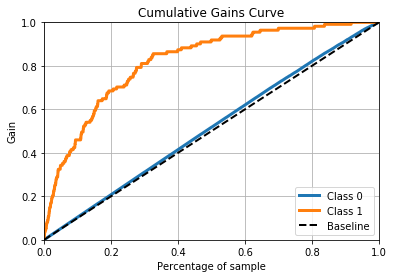

In [131]:
y_pred = xgb_random.predict(x_test)
y_proba = xgb_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [108]:
var_imp = xgb_random.best_estimator_.feature_importances_

var_imp = pd.DataFrame(var_imp)
col_names = x_test.columns.transpose()
col_names = col_names.to_frame()
var_imp_f = pd.concat([col_names.reset_index(drop = True), var_imp.reset_index(drop = True)], axis = 1)
#Export
var_imp_f.to_csv("20181031_var_xgb_2.csv.csv",index=False)
#lift chart data

lift_chart = pd.concat([pd.DataFrame(y_proba[:,1]), y_test.reset_index(drop=True)], axis = 1)
lift_chart.head()
#Export
lift_chart.to_csv("20181031_lift_xgb_2.csv",index=False)

In [73]:
#SVM

# parameter grid for SVM
params = {
        'C' : [0.001, 0.01, 0.1, 1, 10],
        'gamma' : [0.001, 0.01, 0.1, 1],
        }

print(params)

{'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}


In [74]:
svc = SVC(kernel = 'rbf', verbose = True, random_state = 0, probability = True)
svc_random = RandomizedSearchCV(svc, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=True, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
svc_random.fit(x_train_up, y_train_up)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.6min finished


[LibSVM]
 Time taken: 0 hours 11 minutes and 20.97 seconds.


In [56]:
svc_random.best_params_

{'gamma': 1, 'C': 10}

Accuracy: 0.901387874361
Precision: 0.143497757848
Recall: 0.288288288288
ROC_AUC: 0.695696457782
AUC Pr Rc: 0.703077560195
Confusion matrix:
[[2436  191]
 [  79   32]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


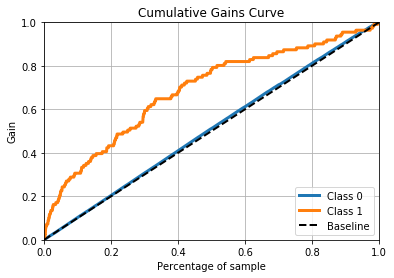

In [75]:
y_pred = svc_random.predict(x_test)
y_proba = svc_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [65]:
metrics.roc_auc_score(y_train_up ,svc_random.predict(x_train_up) )

0.99975665152498372

In [332]:
x_part = df.loc[y_test.index, :]

In [333]:
out = pd.concat([x_part.reset_index(drop = True), y_test.reset_index(drop = True), pd.Series(y_pred)], axis = 1)

In [334]:
#Export
out.to_csv("20181025_test_v1.csv",index=False)

### SMOTE

In [76]:
from imblearn.over_sampling import SMOTE

In [77]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 229
Before OverSampling, counts of label '0': 6159 

After OverSampling, the shape of train_X: (12318, 61)
After OverSampling, the shape of train_y: (12318,) 

After OverSampling, counts of label '1': 6159
After OverSampling, counts of label '0': 6159


In [78]:
x_train_res = pd.DataFrame(x_train_res, columns= x_test.columns)

In [80]:
#logistic Regression
parameters = [{'C': [0.1, 1, 10]}]
model = LogisticRegression(random_state = 0)

# Here we go
start_time = timer(None)

grid_search = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs = -1, scoring= 'roc_auc' )
grid_search = grid_search.fit(x_train_res, y_train_res)
y_pred = grid_search.predict(x_test)

timer(start_time)


 Time taken: 0 hours 0 minutes and 7.84 seconds.


Accuracy: 0.753104455807
Precision: 0.108183079057
Recall: 0.702702702703
ROC_AUC: 0.78467199594
AUC Pr Rc: 0.779994160336
Confusion matrix:
[[1984  643]
 [  33   78]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


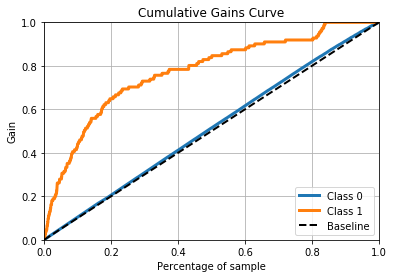

In [81]:
y_pred = grid_search.predict(x_test)
y_proba = grid_search.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [97]:
# Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = RandomForestClassifier(random_state = 0)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=True, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_res, y_train_res)

timer(start_time) # timing ends here for "start_time" variable

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.1min finished



 Time taken: 0 hours 4 minutes and 33.64 seconds.


In [98]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

Accuracy: 0.939737034332
Precision: 0.212765957447
Recall: 0.18018018018
ROC_AUC: 0.788243706211
AUC Pr Rc: 0.763930581566
Confusion matrix:
[[2553   74]
 [  91   20]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


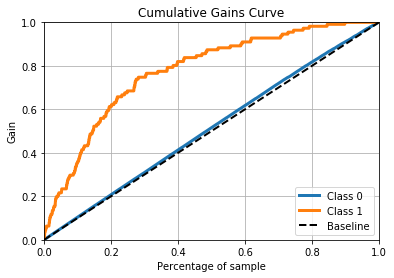

In [109]:
y_pred = rf_random.predict(x_test)
y_proba = rf_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [110]:
# var_imp = rf_random.best_estimator_.feature_importances_

# var_imp = pd.DataFrame(var_imp)
# col_names = x_test.columns.transpose()
# col_names = col_names.to_frame()
# var_imp_f = pd.concat([col_names.reset_index(drop = True), var_imp.reset_index(drop = True)], axis = 1)
# #Export
# var_imp_f.to_csv("20181031_var_xgb_2.csv.csv",index=False)
# #lift chart data

lift_chart = pd.concat([pd.DataFrame(y_proba[:,1]), y_test.reset_index(drop=True)], axis = 1)
lift_chart.head()
#Export
lift_chart.to_csv("20181031_lift_rf_3.csv",index=False)

In [82]:
#XGBoost

# parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

print(params)

{'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]}


In [83]:
xgb = XGBClassifier()

xgb_random = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_random.fit(x_train_res, y_train_res)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.7s finished



 Time taken: 0 hours 0 minutes and 29.42 seconds.


Accuracy: 0.912710007305
Precision: 0.195238095238
Recall: 0.369369369369
ROC_AUC: 0.822467309334
AUC Pr Rc: 0.804888461994
Confusion matrix:
[[2458  169]
 [  70   41]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


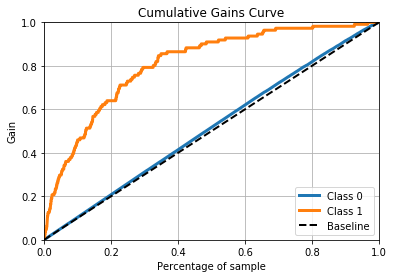

In [84]:
y_pred = xgb_random.predict(x_test)
y_proba = xgb_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [85]:
#SVM

# parameter grid for SVM
params = {
        'C' : [0.001, 0.01, 0.1, 1, 10],
        'gamma' : [0.001, 0.01, 0.1, 1],
        }

print(params)

{'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}


In [86]:
svc = SVC(kernel = 'rbf', verbose = True, random_state = 0, probability = True)
svc_random = RandomizedSearchCV(svc, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=True, random_state=0 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
svc_random.fit(x_train_res, y_train_res)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.2min finished


[LibSVM]
 Time taken: 0 hours 12 minutes and 11.36 seconds.


In [87]:
svc_random.best_params_

{'gamma': 0.1, 'C': 10}

Accuracy: 0.884952520088
Precision: 0.148275862069
Recall: 0.387387387387
ROC_AUC: 0.748771420831
AUC Pr Rc: 0.763620780199
Confusion matrix:
[[2380  247]
 [  68   43]]


C:\Users\136615\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


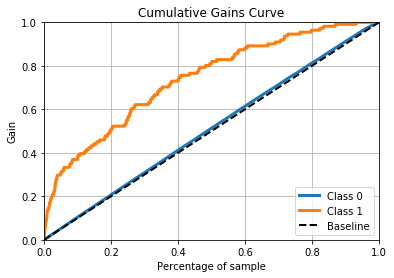

In [88]:
y_pred = svc_random.predict(x_test)
y_proba = svc_random.predict_proba(x_test)
sample_weight = compute_sample_weight("balanced", y_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba[:,1], pos_label = 1, sample_weight = sample_weight)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))
# Model ROC
print("ROC_AUC:", metrics.roc_auc_score(y_test, y_proba[:,1]))
# Model AUC for precision recall
print("AUC Pr Rc:", metrics.auc(recall, precision))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_cumulative_gain(y_test, y_proba)

In [86]:
# validation set

from sklearn.model_selection import train_test_split
x_train1, x_val, y_train1, y_val = train_test_split(x,y,test_size =0.35, random_state = 10)

In [87]:
y_pred = xgb_random.predict(x_val)

# Model Accuracy, how often is the classifier correct

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_val, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_val, y_pred))
# Model ROC
print("ROC:", metrics.roc_auc_score(y_val, y_pred))
#Model confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.808184942206
Precision: 0.14139941691
Recall: 0.795081967213
ROC: 0.801893045964
Confusion matrix:
[[2490  589]
 [  25   97]]


In [142]:
y_pred.sum()

942